In [1]:
# IMPORTER
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path


class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing Jupyter notebook from %s" % path)
                                       
        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


sys.meta_path.append(NotebookFinder())

In [2]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn
import csv

import utils

In [3]:
models_folder = 'saved_models'
model_name = '20200908_multinet'
results_folder = 'saved_results'

In [6]:
all_train_losses = np.load(file=('%s/%s/%s' % (results_folder, model_name, 'all_train_losses.npy')), allow_pickle=True)
all_train_correct = np.load(file=('%s/%s/%s' % (results_folder, model_name, 'all_train_correct.npy')), allow_pickle=True)
all_train_results = np.load(file=('%s/%s/%s' % (results_folder, model_name, 'all_train_results.npy')), allow_pickle=True)

all_val_losses = np.load(file=('%s/%s/%s' % (results_folder, model_name, 'all_val_losses.npy')), allow_pickle=True)
all_val_correct = np.load(file=('%s/%s/%s' % (results_folder, model_name, 'all_val_correct.npy')), allow_pickle=True)
all_val_results = np.load(file=('%s/%s/%s' % (results_folder, model_name, 'all_val_results.npy')), allow_pickle=True)

all_test_losses = np.load(file=('%s/%s/%s' % (results_folder, model_name, 'all_test_losses.npy')), allow_pickle=True)
all_test_correct = np.load(file=('%s/%s/%s' % (results_folder, model_name, 'all_test_correct.npy')), allow_pickle=True)
all_test_results = np.load(file=('%s/%s/%s' % (results_folder, model_name, 'all_test_results.npy')), allow_pickle=True)

fx_labels = np.load(file=('%s/%s/%s' % (results_folder, model_name, 'fx_labels.npy')), allow_pickle=True)

In [7]:
train_set_size = all_train_results.shape[1]
val_set_size = all_val_results.shape[1]
test_set_size = all_test_results.shape[1]

In [8]:
# BEST RESULTS
print('Accuracy: ', 100 * max(all_train_correct) / train_set_size)
print('Epoch: ', np.argmax(all_train_correct))
print()
print('Accuracy: ', 100 * max(all_val_correct) / val_set_size)
print('Epoch: ', np.argmax(all_val_correct))
print()
print('Accuracy: ', 100 * max(all_test_correct) / test_set_size)
print('Epoch: ', np.argmax(all_test_correct))
print()

Accuracy:  49.91632047981922
Epoch:  49

Accuracy:  43.053750286719165
Epoch:  49

Accuracy:  42.84971557893449
Epoch:  49



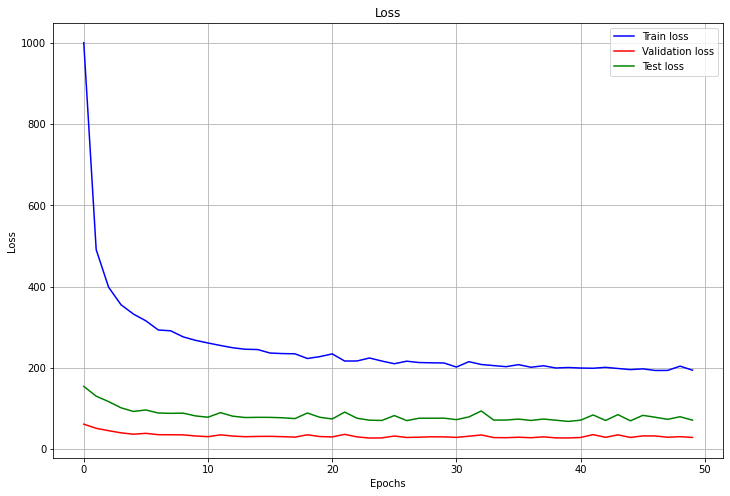

In [10]:
# LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(12,8))
plt.grid(b=None, which='major', axis='both')
plt.plot(epochs, all_train_losses, 'b', label='Train loss')
plt.plot(epochs, all_val_losses, 'r', label='Validation loss')
plt.plot(epochs, all_test_losses, 'g', label='Test loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

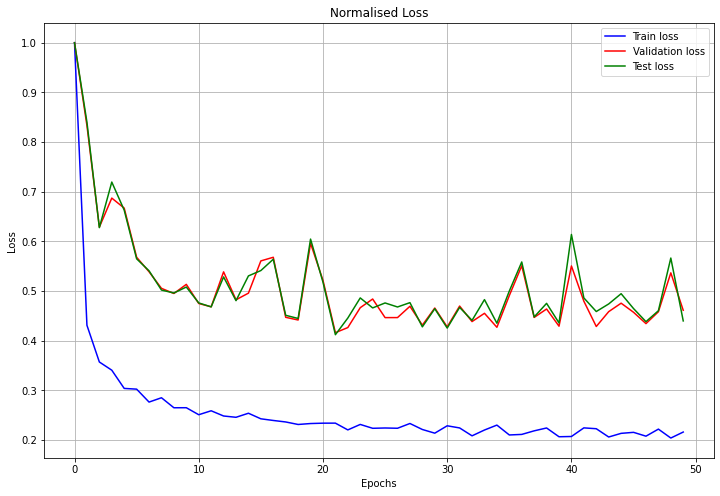

In [31]:
# NORMALISED LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(12,8))
plt.grid(b=None, which='major', axis='both')
plt.plot(epochs, np.array(all_train_losses) / max(all_train_losses), 'b', label='Train loss')
plt.plot(epochs, np.array(all_val_losses) / max(all_val_losses), 'r', label='Validation loss')
plt.plot(epochs, np.array(all_test_losses) / max(all_test_losses), 'g', label='Test loss')
plt.title('Normalised Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

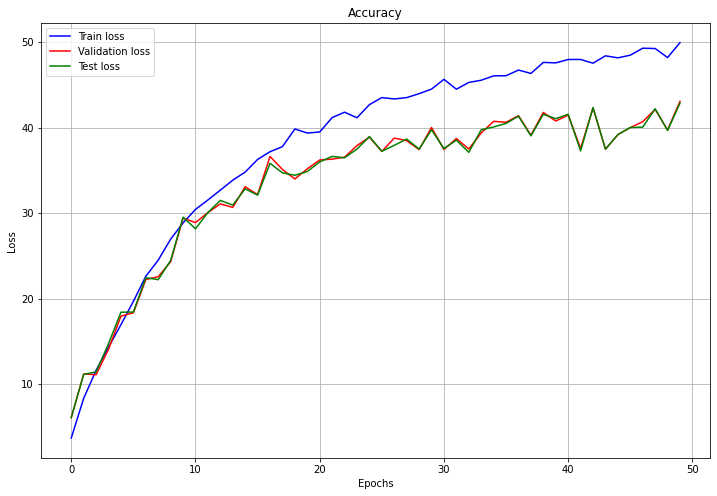

In [11]:
# ACCURACY
all_train_perc_correct = 100 * np.array(all_train_correct) / train_set_size
all_val_perc_correct = 100 * np.array(all_val_correct) / val_set_size
all_test_perc_correct = 100 * np.array(all_test_correct) / test_set_size
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(12,8))
plt.grid(b=None, which='major', axis='both')
plt.plot(epochs, all_train_perc_correct, 'b', label='Train loss')
plt.plot(epochs, all_val_perc_correct, 'r', label='Validation loss')
plt.plot(epochs, all_test_perc_correct, 'g', label='Test loss')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
# CONFUSION MATRICES

# Find best performance epoch based on validation
# Extract results from training and test for that epoch
best_val = 100 * max(all_val_correct) / val_set_size
best_val_idx = np.argmax(all_val_correct)

print("Best Validation Accuracy: ",best_val, "at epoch ", best_val_idx)
print("Training Accuracy: ", 100 * all_train_correct[best_val_idx] / train_set_size)
print("Test Accuracy: ", 100 * all_test_correct[best_val_idx] / test_set_size)

# Confusion matrices for best validation epoch
# extract predictions and targets vectors
train_preds = all_train_results[best_val_idx, :, 2]
train_targets = all_train_results[best_val_idx, :, 3]
val_preds = all_val_results[best_val_idx, :, 2]
val_targets = all_val_results[best_val_idx, :, 3]
test_preds = all_test_results[best_val_idx, :, 2]
test_targets = all_test_results[best_val_idx, :, 3]

# calculate conf. matrix
train_cm = confusion_matrix(train_targets, train_preds)
val_cm = confusion_matrix(val_targets, val_preds)
test_cm = confusion_matrix(test_targets, test_preds)

Best Validation Accuracy:  91.21990004543389 at epoch  46
Training Accuracy:  91.92204776089261
Test Accuracy:  91.04416575790621


Normalized confusion matrix


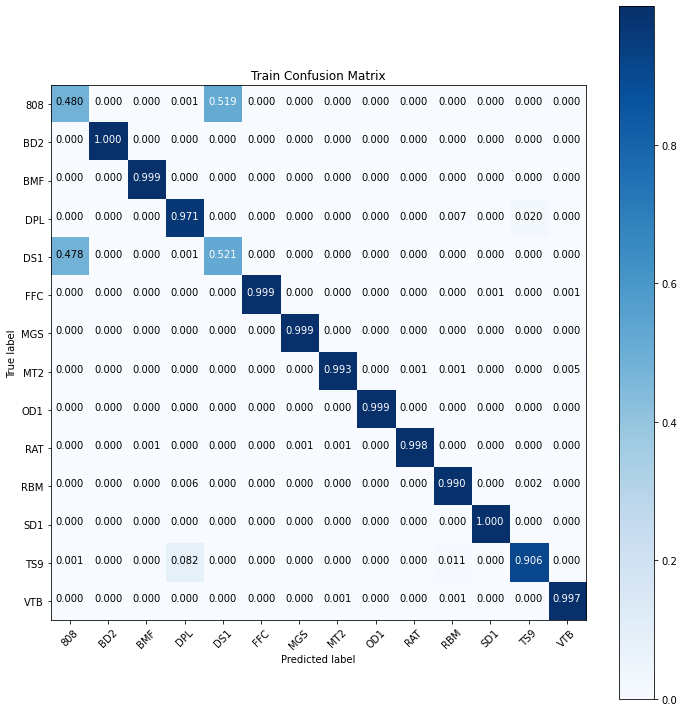

In [34]:
# Train CM
plt.figure(figsize=(10,10))
utils.plot_confusion_matrix(train_cm, fx_labels, normalize=True, title='Train Confusion Matrix')

Normalized confusion matrix


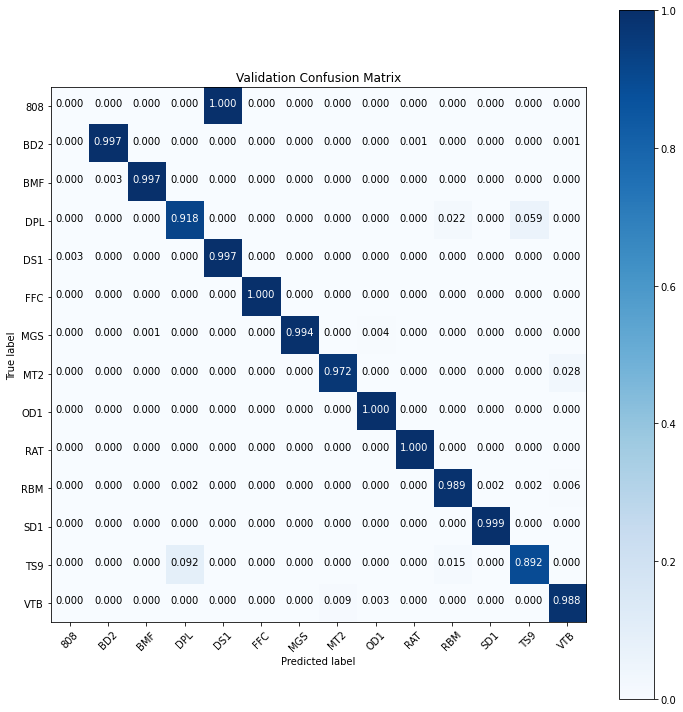

In [35]:
plt.figure(figsize=(10,10))
utils.plot_confusion_matrix(val_cm, fx_labels, normalize=True, title='Validation Confusion Matrix')

Normalized confusion matrix


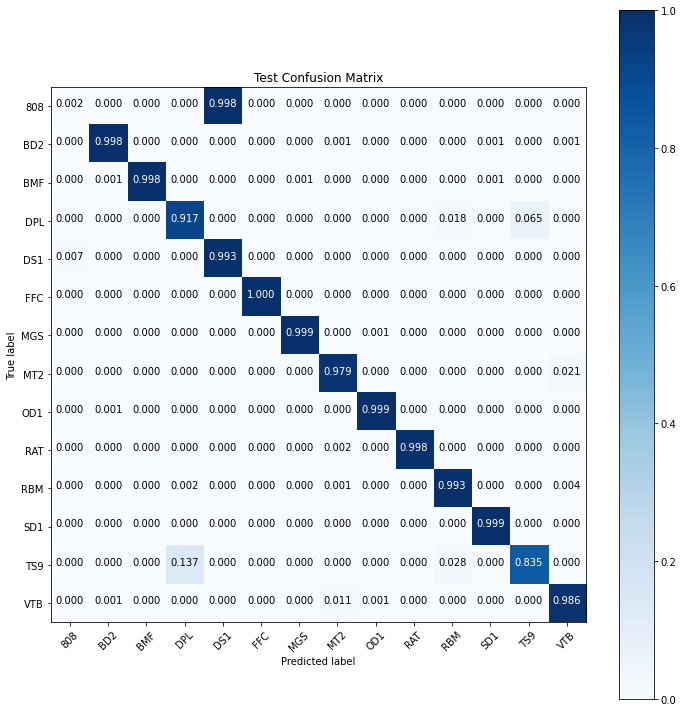

In [36]:
# Test CM
plt.figure(figsize=(10,10))
utils.plot_confusion_matrix(test_cm, fx_labels, normalize=True, title='Test Confusion Matrix')

In [37]:
# SAVE RESULTS for best epoch

# write train results to csv file
train_results_sorted = all_train_results[best_val_idx].tolist()
for i in range(len(train_results_sorted)):
    train_results_sorted[i][0] = int(train_results_sorted[i][0])
train_results_sorted = sorted(train_results_sorted)
with open('%s/%s/%s' % (results_folder, model_name, 'train_fxnet_results.csv'), mode='w') as file:
    wrt = csv.writer(file)
    wrt.writerow(['index','filename','prediction','label'])
    for row in train_results_sorted:
        wrt.writerow(row)

# write validation results to csv file
val_results_sorted = all_val_results[best_val_idx].tolist()
for i in range(len(val_results_sorted)):
    val_results_sorted[i][0] = int(val_results_sorted[i][0])
val_results_sorted = sorted(val_results_sorted)
with open('%s/%s/%s' % (results_folder, model_name, 'val_fxnet_results.csv'), mode='w') as file:
    wrt = csv.writer(file)
    wrt.writerow(['index','filename','prediction','label'])
    for row in val_results_sorted:
        wrt.writerow(row)

# write test results to csv file
test_results_sorted = all_test_results[best_val_idx].tolist()
for i in range(len(test_results_sorted)):
    test_results_sorted[i][0] = int(test_results_sorted[i][0])
test_results_sorted = sorted(test_results_sorted)
with open('%s/%s/%s' % (results_folder, model_name, 'test_fxnet_results.csv'), mode='w') as file:
    wrt = csv.writer(file)
    wrt.writerow(['index','filename','prediction','label'])
    for row in test_results_sorted:
        wrt.writerow(row)